In [1]:
! ls raw

diagnosis.csv        medrecon.csv         vitalsign.csv
edstays.csv          pyxis.csv
icd9toicd10cmgem.csv triage.csv


In [1]:
import os 
os.getcwd()
import numpy as np
import sklearn.preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
nlp = spacy.load('en_core_web_sm')
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from scipy import stats

In [2]:
def look_n_load(path):
    df = pd.read_csv(path)
    print('\nShape:', df.shape)
    print('\nColumns:', list(df.columns))
#     print('\n',df.describe())
    print('\nMissing proportions:\n', df.isna().sum()/len(df))
    return df

# 1. Data overview

## 1.1 Diagnostic table

In [3]:
diagnosis = look_n_load('raw/diagnosis.csv')


Shape: (946692, 6)

Columns: ['subject_id', 'stay_id', 'seq_num', 'icd_code', 'icd_version', 'icd_title']

Missing proportions:
 subject_id     0.0
stay_id        0.0
seq_num        0.0
icd_code       0.0
icd_version    0.0
icd_title      0.0
dtype: float64


In [4]:
diagnosis[diagnosis['icd_code'].str.startswith("0")]

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title


In [5]:
icd_conversion = pd.read_csv('raw/icd9toicd10cmgem.csv')

In [7]:
icd_conversion

,icd9cm,icd10cm,flags,approximate,no_map,combination,scenario,choice_list
0,0010,A000,0,0,0,0,0,0
1,0011,A001,0,0,0,0,0,0
2,0019,A009,0,0,0,0,0,0
3,0020,A0100,10000,1,0,0,0,0
4,0021,A011,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
23907,V9129,O30299,10000,1,0,0,0,0
23908,V9190,O30809,10000,1,0,0,0,0
23909,V9191,O30819,10000,1,0,0,0,0
23910,V9192,O30829,10000,1,0,0,0,0


In [6]:
diagnosis_1 = pd.merge(diagnosis,icd_conversion[['icd9cm','icd10cm']],how='left',left_on='icd_code',right_on='icd9cm')

In [7]:
diagnosis_1[(diagnosis_1.icd_version == 9) & (diagnosis_1['icd10cm'].isna())]

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title,icd9cm,icd10cm
1,10000032,32952584,2,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,NaN,NaN
6,10000032,33258284,3,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,NaN,NaN
14,10000032,38112554,2,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,NaN,NaN
280,10002157,31887902,1,88,9,VIRAL ENTERITIS NOS,NaN,NaN
467,10002930,31579293,2,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,NaN,NaN
...,...,...,...,...,...,...,...,...
1197929,19983860,36599398,3,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,NaN,NaN
1197945,19983948,38567517,1,8881,9,LYME DISEASE,NaN,NaN
1198018,19985000,39581850,1,845,9,CLOSTRIDIUM DIFFICILE,NaN,NaN
1198168,19985885,38207246,1,539,9,HERPES ZOSTER NOS,NaN,NaN


In [8]:
diagnosis_1[(diagnosis_1.icd_version == 9) & (diagnosis_1['icd10cm'].isna())].icd_code.value_counts()

7070    1045
389      904
539      302
7054     182
845      131
        ... 
9959       1
85         1
37         1
543        1
794        1
Name: icd_code, Length: 104, dtype: int64

This NA case because some code in Version9 doesn't have exactly same code in Version 10, therefore we keep icd code version 9 for these case

In [9]:
diagnosis_1['fin_code'] = diagnosis_1['icd_code']
diagnosis_1.loc[diagnosis_1.icd_version == 9, 'fin_code'] = diagnosis_1.loc[diagnosis_1.icd_version == 9,'icd10cm']

In [10]:
diagnosis_1.loc[diagnosis_1.fin_code.isna(),'fin_code'] = diagnosis_1.loc[diagnosis_1.fin_code.isna(),'icd_code']

In [11]:
diagnosis_1

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title,icd9cm,icd10cm,fin_code
0,10000032,32952584,1,4589,9,HYPOTENSION NOS,4589,I959,I959
1,10000032,32952584,2,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,NaN,NaN,7070
2,10000032,32952584,3,V08,9,ASYMPTOMATIC HIV INFECTION,V08,Z21,Z21
3,10000032,33258284,1,5728,9,"OTH SEQUELA, CHR LIV DIS",5728,K7210,K7210
4,10000032,33258284,1,5728,9,"OTH SEQUELA, CHR LIV DIS",5728,K7290,K7290
...,...,...,...,...,...,...,...,...,...
1199788,19999828,30712109,1,K632,10,Fistula of intestine,NaN,NaN,K632
1199789,19999828,32917002,1,E1110,10,Type 2 diabetes mellitus with ketoacidosis wit...,NaN,NaN,E1110
1199790,19999828,32917002,2,Z7984,10,Long term (current) use of oral hypoglycemic d...,NaN,NaN,Z7984
1199791,19999914,32002659,1,R4182,10,"Altered mental status, unspecified",NaN,NaN,R4182


In [12]:
diagnosis_1['fin_code_group'] = diagnosis_1['fin_code'].apply(lambda x: x[:3])

In [13]:
diagnosis_1

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title,icd9cm,icd10cm,fin_code,fin_code_group
0,10000032,32952584,1,4589,9,HYPOTENSION NOS,4589,I959,I959,I95
1,10000032,32952584,2,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,NaN,NaN,7070,707
2,10000032,32952584,3,V08,9,ASYMPTOMATIC HIV INFECTION,V08,Z21,Z21,Z21
3,10000032,33258284,1,5728,9,"OTH SEQUELA, CHR LIV DIS",5728,K7210,K7210,K72
4,10000032,33258284,1,5728,9,"OTH SEQUELA, CHR LIV DIS",5728,K7290,K7290,K72
...,...,...,...,...,...,...,...,...,...,...
1199788,19999828,30712109,1,K632,10,Fistula of intestine,NaN,NaN,K632,K63
1199789,19999828,32917002,1,E1110,10,Type 2 diabetes mellitus with ketoacidosis wit...,NaN,NaN,E1110,E11
1199790,19999828,32917002,2,Z7984,10,Long term (current) use of oral hypoglycemic d...,NaN,NaN,Z7984,Z79
1199791,19999914,32002659,1,R4182,10,"Altered mental status, unspecified",NaN,NaN,R4182,R41


In [14]:
diagnosis_1['key'] = diagnosis_1['subject_id'].astype(str)+'_'+diagnosis_1['stay_id'].astype(str)

In [17]:
cat_encoder = sklearn.preprocessing.OneHotEncoder()
diagnosis_1_transformed = cat_encoder.fit_transform(diagnosis_1[['fin_code_group']])
diagnosis_1_transformed.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
len(cat_encoder.categories_[0])

1575

In [19]:
icd_trans = diagnosis_1_transformed.toarray()

In [20]:
dict_diag = {}

for i in range(len(diagnosis_1)):
    if diagnosis_1['seq_num'][i] == 1:
        dict_diag[diagnosis_1['key'][i]] = icd_trans[i]
    else: 
        dict_diag[diagnosis_1['key'][i]] = icd_trans[i] + dict_diag.get(diagnosis_1['key'][i])

In [21]:
print(len(dict_diag.get('10000032_32952584')))
sum(dict_diag.get('10000032_32952584'))

1575


3.0

In [22]:
X = np.array(list(dict_diag.values()))
pca = PCA(n_components=100)
pca.fit(X)

PCA(n_components=100)

In [23]:
pca.explained_variance_ratio_

array([0.13715068, 0.04275716, 0.03934781, 0.02842164, 0.02309099,
       0.02231281, 0.02073891, 0.01806164, 0.01668379, 0.0163314 ,
       0.01506659, 0.01427979, 0.0134955 , 0.01313689, 0.01288739,
       0.01196694, 0.01129489, 0.01077978, 0.01011906, 0.00998809,
       0.00979603, 0.00938744, 0.00919518, 0.00905796, 0.00844033,
       0.00817884, 0.00769642, 0.00748982, 0.00702919, 0.00652955,
       0.00626589, 0.00609892, 0.00604297, 0.00601028, 0.00594399,
       0.00569846, 0.00553374, 0.00523274, 0.00504146, 0.0049552 ,
       0.00490911, 0.00477021, 0.004423  , 0.00430356, 0.00419663,
       0.00412217, 0.00393727, 0.0039082 , 0.00372119, 0.00356295,
       0.00352887, 0.00351094, 0.00339335, 0.00326034, 0.003156  ,
       0.00315194, 0.0031381 , 0.00311231, 0.00309749, 0.00304135,
       0.00302006, 0.00299559, 0.00292666, 0.00291714, 0.00282168,
       0.00276207, 0.00274282, 0.00268633, 0.00261999, 0.00253588,
       0.00246866, 0.00235315, 0.00234549, 0.00229726, 0.00227

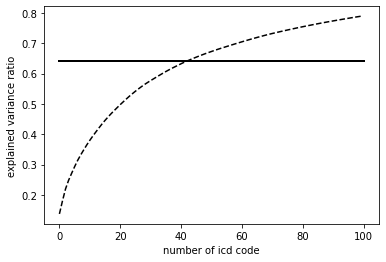

In [24]:
plt.plot(pca.explained_variance_ratio_.cumsum(), 'k--')
plt.plot([0, 100],[0.64,0.64], 'k-', lw=2)
plt.ylabel('explained variance ratio')
plt.xlabel('number of icd code')
plt.show()

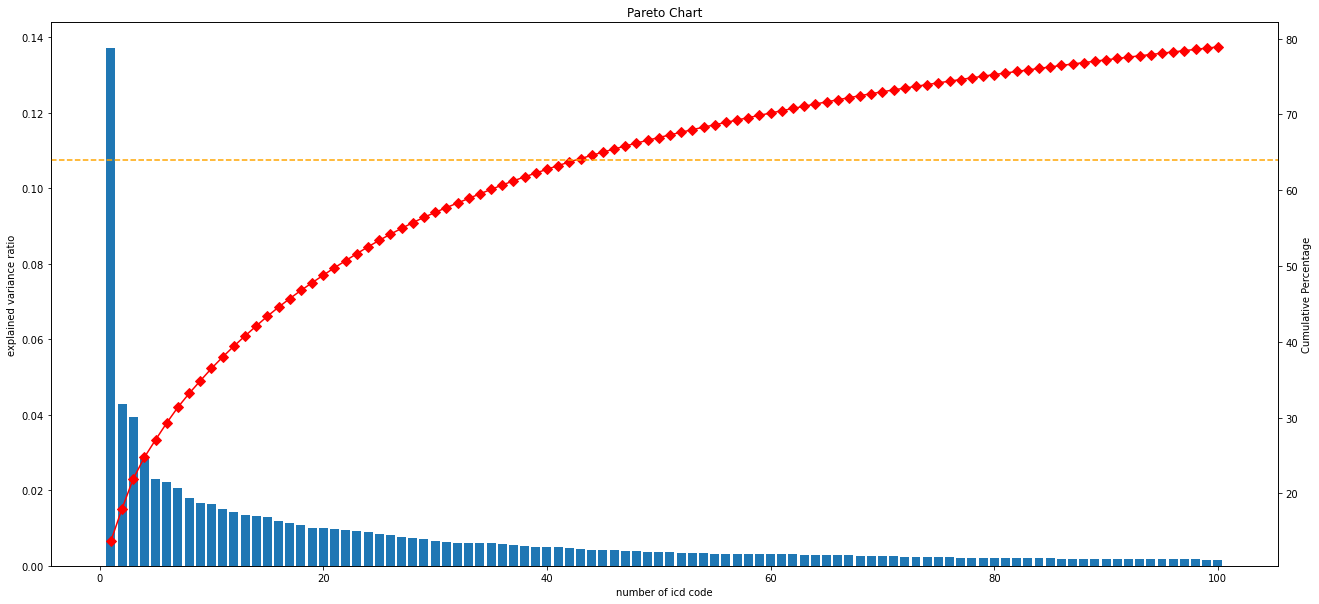

In [25]:
# Set figure and axis
fig, ax = plt.subplots(figsize=(22,10))

# Plot bars (i.e. frequencies)
ax.bar(list(range(1,101)), pca.explained_variance_ratio_)
ax.set_title("Pareto Chart")
ax.set_xlabel("number of icd code")
ax.set_ylabel("explained variance ratio");

# Second y axis (i.e. cumulative percentage)
ax2 = ax.twinx()
ax2.plot(list(range(1,101)), pca.explained_variance_ratio_.cumsum()*100, color="red", marker="D", ms=7)
ax2.axhline(64, color="orange", linestyle="dashed")
#ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage");

In [26]:
pca.explained_variance_ratio_.cumsum()

array([0.13715068, 0.17990784, 0.21925565, 0.24767729, 0.27076828,
       0.29308109, 0.31382   , 0.33188164, 0.34856543, 0.36489683,
       0.37996342, 0.39424321, 0.40773872, 0.42087561, 0.433763  ,
       0.44572994, 0.45702483, 0.4678046 , 0.47792366, 0.48791175,
       0.49770777, 0.50709521, 0.51629039, 0.52534835, 0.53378868,
       0.54196753, 0.54966395, 0.55715377, 0.56418297, 0.57071252,
       0.57697841, 0.58307733, 0.5891203 , 0.59513058, 0.60107458,
       0.60677304, 0.61230678, 0.61753952, 0.62258098, 0.62753619,
       0.6324453 , 0.63721551, 0.64163851, 0.64594207, 0.6501387 ,
       0.65426087, 0.65819813, 0.66210633, 0.66582752, 0.66939047,
       0.67291934, 0.67643028, 0.67982363, 0.68308397, 0.68623996,
       0.68939191, 0.69253001, 0.69564232, 0.69873981, 0.70178116,
       0.70480122, 0.70779681, 0.71072347, 0.71364061, 0.71646228,
       0.71922435, 0.72196717, 0.7246535 , 0.72727349, 0.72980937,
       0.73227804, 0.73463119, 0.73697667, 0.73927394, 0.74155

In [15]:
edstays = look_n_load('raw/edstays.csv')


Shape: (447712, 9)

Columns: ['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender', 'race', 'arrival_transport', 'disposition']

Missing proportions:
 subject_id           0.000000
hadm_id              0.522213
stay_id              0.000000
intime               0.000000
outtime              0.000000
gender               0.000000
race                 0.000000
arrival_transport    0.000000
disposition          0.000000
dtype: float64


In [16]:
edstays['disposition'].value_counts()

HOME                           254545
ADMITTED                       166303
TRANSFER                         7436
LEFT WITHOUT BEING SEEN          6516
ELOPED                           6011
OTHER                            4520
LEFT AGAINST MEDICAL ADVICE      1986
EXPIRED                           395
Name: disposition, dtype: int64

array([<AxesSubplot:ylabel='disposition'>], dtype=object)

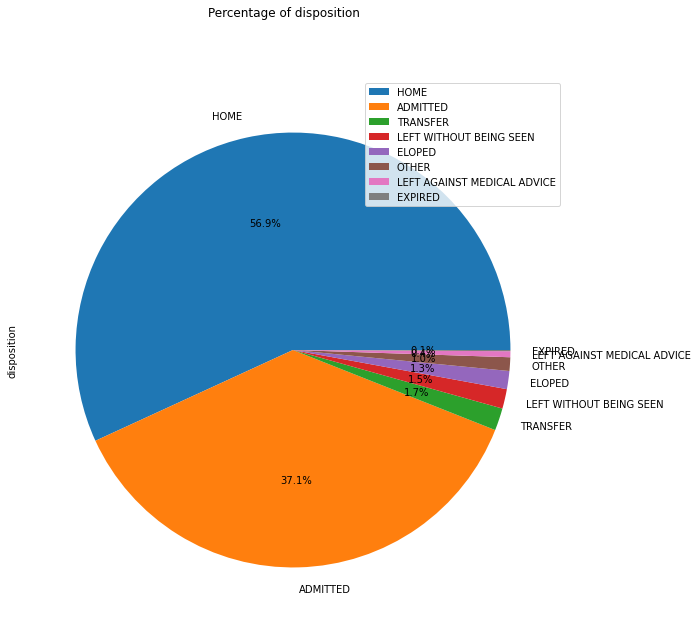

In [17]:
cls_table = pd.DataFrame(edstays['disposition'].value_counts(normalize=True))
cls_table.plot(kind='pie', y = 'disposition',subplots=True, autopct='%1.1f%%', title = "Percentage of disposition", figsize=(10,10))

In [18]:
edstays['y_var_adm_text'] = edstays['disposition']

In [19]:
edstays.loc[edstays['y_var_adm_text'] == 'TRANSFER', 'y_var_adm_text'] = 'ADMITTED'
edstays.loc[edstays['y_var_adm_text'] == 'ELOPED','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'LEFT WITHOUT BEING SEEN','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'OTHER','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'LEFT AGAINST MEDICAL ADVICE','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'EXPIRED','y_var_adm_text'] = 'MISSING'

In [20]:
edstays_admit = edstays[edstays['y_var_adm_text'] !='MISSING'].reset_index(drop = True)

array([<AxesSubplot:ylabel='y_var_adm_text'>], dtype=object)

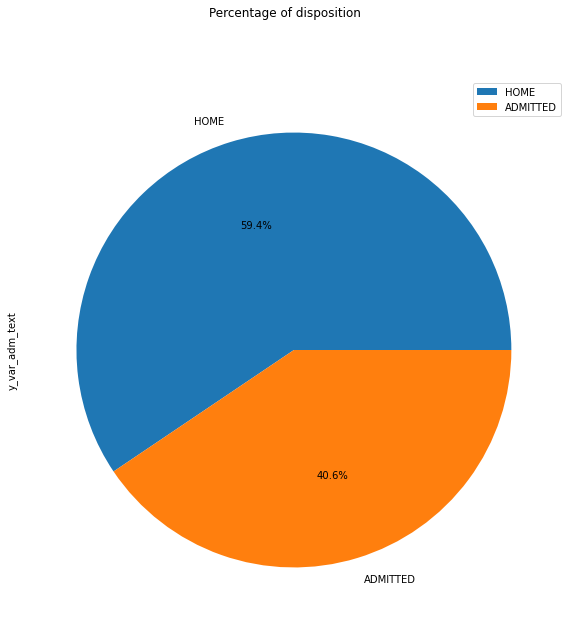

In [21]:
cls_table = pd.DataFrame(edstays_admit['y_var_adm_text'].value_counts(normalize=True))
cls_table.plot(kind='pie', y = 'y_var_adm_text',subplots=True, autopct='%1.1f%%', title = "Percentage of disposition", figsize=(10,10))

In [22]:
edstays_admit['key'] = edstays_admit['subject_id'].astype(str)+'_'+edstays_admit['stay_id'].astype(str)

In [23]:
edstays_admit

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,key
0,10000032,22595853.0,33258284,6/5/2180 19:17,6/5/2180 23:30,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_33258284
1,10000032,22841357.0,38112554,26/6/2180 15:54,26/6/2180 21:31,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_38112554
2,10000032,25742920.0,35968195,5/8/2180 20:58,6/8/2180 1:44,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_35968195
3,10000032,29079034.0,32952584,22/7/2180 16:24,23/7/2180 5:54,F,WHITE,AMBULANCE,HOME,HOME,10000032_32952584
4,10000032,29079034.0,39399961,23/7/2180 5:54,23/7/2180 14:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_39399961
...,...,...,...,...,...,...,...,...,...,...,...
428279,19999784,25715748.0,34149746,11/8/2119 9:15,11/8/2119 13:40,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_34149746
428280,19999784,26194817.0,35692999,18/6/2119 14:21,18/6/2119 21:09,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_35692999
428281,19999828,25744818.0,32917002,8/1/2149 9:11,8/1/2149 18:12,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,19999828_32917002
428282,19999828,29734428.0,30712109,17/7/2147 17:18,18/7/2147 17:34,F,WHITE,WALK IN,ADMITTED,ADMITTED,19999828_30712109


In [36]:
ad_y_dict = {}
for i in range(len(edstays_admit)):
    if edstays_admit['y_var_adm_text'][i] == 'ADMITTED':
        ad_y_dict[edstays_admit['key'][i]] = 1
    else:
        ad_y_dict[edstays_admit['key'][i]] = 0

In [37]:
dict_icd_map_y = {}

for key in set(dict_diag.keys() & ad_y_dict.keys()):
    dict_icd_map_y.setdefault(key,[]).append(ad_y_dict[key])
    dict_icd_map_y.setdefault(key,[]).append(dict_diag[key])      
    


In [38]:
list(dict_icd_map_y.values())[2][1][0]

0.0

In [39]:
X = np.array(list(dict_icd_map_y.values()))

/var/folders/_c/m6hnqfdn1mb6n5wgf1vjzrlc0000gn/T/ipykernel_9157/3346590483.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(list(dict_icd_map_y.values()))


dict_icd_ad_rate = {}

for i in range(len(cat_encoder.categories_[0])):
    list_b = []
    for j in range(len(X)):
        if X[j][1][i] > 0:
            list_b.extend([X[j][0]])
    if len(list_b) > 0:
        dict_icd_ad_rate[list(cat_encoder.categories_[0])[i]] = np.mean([list_b])
    else:
        dict_icd_ad_rate[list(cat_encoder.categories_[0])[i]] = 0

df = pd.DataFrame.from_dict(dict_icd_ad_rate,orient = 'index',columns=['Admission_rate'])

df['icd_group'] = df.index

df.sort_values(by='Admission_rate',ascending=False).reset_index(drop=True)

df.to_csv('icd_group_admission_rate')

ax = df.plot.hist(column=["Admission_rate"],figsize=(15,5))
ax.set_xlabel("Admission_rate")
ax.set_ylabel("Number of icd_group")

In [40]:
X_lst = []
Y_lst = []
for i in range(len(X)):
    X_lst.append(X[i][1])
    Y_lst.extend([X[i][0]])
X_lst=np.array(X_lst)

In [41]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_lst, Y_lst)

SelectKBest(k='all', score_func=<function chi2 at 0x7f85ff3aa280>)

In [42]:
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (cat_encoder.categories_[0][i], fs.scores_[i]))

Feature 119: 7.335094
Feature 20: 1.467019
Feature 30: 1.467019
Feature 312: 0.849910
Feature 341: 0.681654
Feature 35: 2.044963
Feature 37: 0.681654
Feature 384: 1.467019
Feature 389: 1262.072786
Feature 400: 4.401057
Feature 410: 5.868076
Feature 411: 2.438767
Feature 417: 4.559521
Feature 418: 9.856031
Feature 419: 14.939984
Feature 42: 20.512653
Feature 478: 1.467019
Feature 479: 15.244572
Feature 498: 1.467019
Feature 529: 4.771581
Feature 530: 4.401057
Feature 531: 2.803341
Feature 532: 2.017201
Feature 539: 45.887792
Feature 540: 1.467019
Feature 541: 19.996839
Feature 543: 1.467019
Feature 544: 2.000940
Feature 546: 2.120240
Feature 547: 1.363309
Feature 549: 16.140426
Feature 579: 5.162268
Feature 59: 6.816545
Feature 663: 0.681654
Feature 701: 1.467019
Feature 703: 2.771727
Feature 705: 117.610476
Feature 707: 12.926243
Feature 709: 0.849910
Feature 71: 1.363309
Feature 74: 0.849910
Feature 740: 2.044963
Feature 743: 5.453236
Feature 75: 17.643925
Feature 778: 0.681654
Featur

In [43]:
dict_icd_fs_chi2 = {}
for i in range(len(fs.scores_)):
	dict_icd_fs_chi2[cat_encoder.categories_[0][i]]= fs.scores_[i]


In [44]:
df = pd.DataFrame.from_dict(dict_icd_fs_chi2,orient = 'index',columns=['fs_score'])
df['icd_group'] = df.index

In [45]:
df.to_csv('icd_chi2fs.csv')

In [46]:
df = df.dropna()

In [47]:
df = df.sort_values(by='fs_score',ascending=False).reset_index(drop=True)

Text(0, 0.5, 'Number of icd_group')

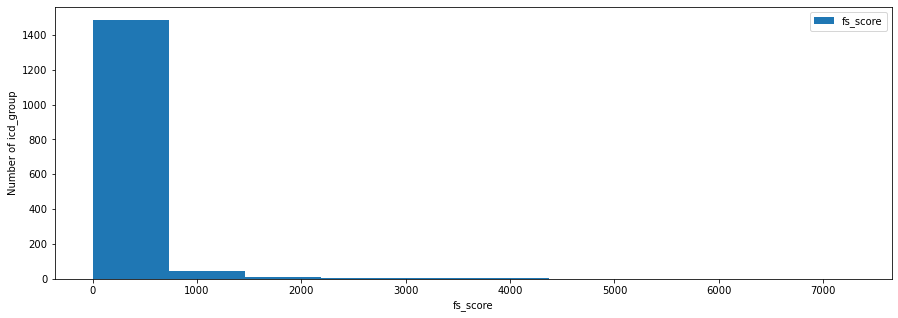

In [48]:
ax = df.plot.hist(column=["fs_score"],figsize=(15,5))
ax.set_xlabel("fs_score")
ax.set_ylabel("Number of icd_group")

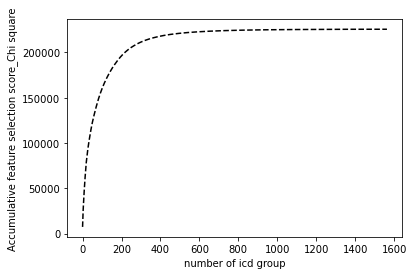

In [49]:
plt.plot(np.array(df.fs_score).cumsum(), 'k--')
plt.ylabel('Accumulative feature selection score_Chi square')
plt.xlabel('number of icd group')
plt.show()

param_grid = [{'min_samples_split':[10,50,100]}]

grid_search = GridSearchCV(ExtraTreesClassifier(bootstrap = True,n_jobs = -1,random_state = 123), param_grid, cv=3,
                           scoring='accuracy',
                           verbose = 1)
grid_search.fit(X_lst,Y_lst)


In [51]:
model = ExtraTreesClassifier(bootstrap = True,n_jobs = -1,random_state = 123, min_samples_leaf=100)
model.fit(X_lst, Y_lst)

ExtraTreesClassifier(bootstrap=True, min_samples_leaf=100, n_jobs=-1,
                     random_state=123)

In [52]:
print(model.feature_importances_) 

[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 8.72413551e-06 1.05473752e-05]


In [59]:
dict_icd_fs_extratree = {}
for i in range(len(model.feature_importances_)):
	dict_icd_fs_extratree[cat_encoder.categories_[0][i]]= model.feature_importances_[i]


In [79]:
df = pd.DataFrame.from_dict(dict_icd_fs_extratree,orient = 'index',columns=['fs_score'])
df['icd_group'] = df.index

In [61]:
df.to_csv('icd_extratreefs.csv')

In [80]:
df = df.sort_values(by='fs_score',ascending=False).reset_index(drop=True)

Text(0, 0.5, 'Number of icd_group')

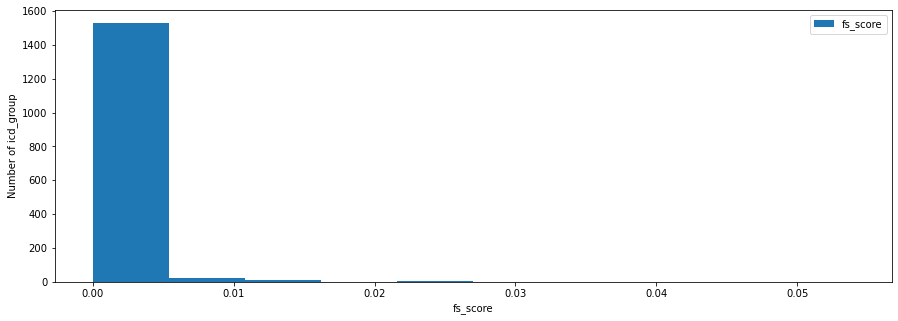

In [81]:
ax = df.plot.hist(column=["fs_score"],figsize=(15,5))
ax.set_xlabel("fs_score")
ax.set_ylabel("Number of icd_group")

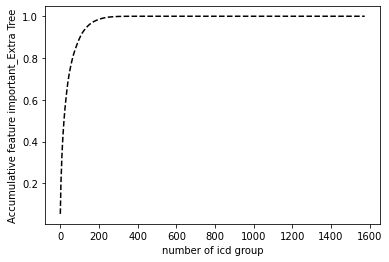

In [82]:
plt.plot(np.array(df.fs_score).cumsum(), 'k--')
plt.ylabel('Accumulative feature important_Extra Tree')
plt.xlabel('number of icd group')
plt.show()

## 1.2 Edstay table

In [26]:
list_diagnosis_leftjoin_in_edstay = pd.merge(diagnosis_1,edstays_admit,how='left', on = 'key')

In [27]:
list_diagnosis_not_in_edstay = set(list_diagnosis_leftjoin_in_edstay[list_diagnosis_leftjoin_in_edstay['intime'].isna()]['key'].to_list())

In [28]:
len(list_diagnosis_not_in_edstay)

19267

19.267 key in diagostic not in edstay (after remove invalid outcome)

In [29]:
key_diag_df = pd.DataFrame(set(diagnosis_1['key'].to_list()),columns=['key_diag'])

In [30]:
list_diagnosis_rightjoin_in_edstay = pd.merge(key_diag_df,edstays_admit,how='right', left_on='key_diag', right_on='key')

In [31]:
list_edstay_not_in_diagnosis = list_diagnosis_rightjoin_in_edstay[list_diagnosis_rightjoin_in_edstay['key_diag'].isna()]

In [32]:
list_edstay_not_in_diagnosis

,key_diag,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,key
288,NaN,10005909,20199380.0,32719751,28/10/2144 18:29,29/10/2144 0:10,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10005909_32719751
343,NaN,10007462,29383640.0,34572020,13/1/2132 15:02,13/1/2132 17:49,M,HISPANIC/LATINO - PUERTO RICAN,WALK IN,ADMITTED,ADMITTED,10007462_34572020
468,NaN,10010655,24811327.0,34867382,28/8/2167 1:00,29/8/2167 19:51,F,BLACK/AFRICAN AMERICAN,AMBULANCE,TRANSFER,ADMITTED,10010655_34867382
1044,NaN,10023349,24313094.0,34494442,16/6/2163 12:06,20/6/2163 15:50,M,HISPANIC/LATINO - CUBAN,AMBULANCE,HOME,HOME,10023349_34494442
1290,NaN,10027100,NaN,36893425,15/8/2156 4:18,15/8/2156 8:09,M,BLACK/AFRICAN AMERICAN,UNKNOWN,HOME,HOME,10027100_36893425
...,...,...,...,...,...,...,...,...,...,...,...,...
425965,NaN,19940888,26227054.0,34464867,25/4/2113 7:58,26/4/2113 19:35,F,WHITE,WALK IN,TRANSFER,ADMITTED,19940888_34464867
427186,NaN,19972235,21800879.0,32088734,26/7/2177 15:43,27/7/2177 7:14,M,WHITE,AMBULANCE,ADMITTED,ADMITTED,19972235_32088734
427472,NaN,19979469,24852288.0,30152667,23/7/2202 12:05,23/7/2202 18:19,M,WHITE,WALK IN,ADMITTED,ADMITTED,19979469_30152667
427919,NaN,19990821,27777812.0,35896332,6/3/2143 15:06,6/3/2143 16:21,M,UNKNOWN,UNKNOWN,ADMITTED,ADMITTED,19990821_35896332


In [33]:
list_edstay_not_in_diagnosis['y_var_adm_text'].value_counts()

ADMITTED    549
HOME        472
Name: y_var_adm_text, dtype: int64

1.021 observation is missing icd code data, in which 549 is admitted and 472 is home

In [34]:
edstays_admit_1 = pd.merge(edstays_admit,key_diag_df,how='inner', left_on='key', right_on='key_diag')

In [35]:
edstays_admit_1

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,key,key_diag
0,10000032,22595853.0,33258284,6/5/2180 19:17,6/5/2180 23:30,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_33258284,10000032_33258284
1,10000032,22841357.0,38112554,26/6/2180 15:54,26/6/2180 21:31,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_38112554,10000032_38112554
2,10000032,25742920.0,35968195,5/8/2180 20:58,6/8/2180 1:44,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_35968195,10000032_35968195
3,10000032,29079034.0,32952584,22/7/2180 16:24,23/7/2180 5:54,F,WHITE,AMBULANCE,HOME,HOME,10000032_32952584,10000032_32952584
4,10000032,29079034.0,39399961,23/7/2180 5:54,23/7/2180 14:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_39399961,10000032_39399961
...,...,...,...,...,...,...,...,...,...,...,...,...
427258,19999784,25715748.0,34149746,11/8/2119 9:15,11/8/2119 13:40,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_34149746,19999784_34149746
427259,19999784,26194817.0,35692999,18/6/2119 14:21,18/6/2119 21:09,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_35692999,19999784_35692999
427260,19999828,25744818.0,32917002,8/1/2149 9:11,8/1/2149 18:12,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,19999828_32917002,19999828_32917002
427261,19999828,29734428.0,30712109,17/7/2147 17:18,18/7/2147 17:34,F,WHITE,WALK IN,ADMITTED,ADMITTED,19999828_30712109,19999828_30712109


427.263 obs has diagnostic information

In [36]:
edstays_admit_1['DateTime_in'] = pd.to_datetime(edstays_admit_1['intime'], format='%d/%m/%Y %H:%M')
edstays_admit_1['DateTime_out'] = pd.to_datetime(edstays_admit_1['outtime'], format='%d/%m/%Y %H:%M')

In [37]:
edstays_admit_1['stay'] = edstays_admit_1['DateTime_out'] - edstays_admit_1['DateTime_in']

In [38]:
edstays_admit_1[(edstays_admit_1.DateTime_out<edstays_admit_1.DateTime_in) | (edstays_admit_1.DateTime_out==edstays_admit_1.DateTime_in)]

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,key,key_diag,DateTime_in,DateTime_out,stay
3557,10086553,NaN,31130161,17/6/2131 23:58,17/6/2131 23:34,F,WHITE,WALK IN,HOME,HOME,10086553_31130161,10086553_31130161,2131-06-17 23:58:00,2131-06-17 23:34:00,-1 days +23:36:00
61907,11458820,NaN,37308943,14/5/2135 21:59,14/5/2135 4:10,F,OTHER,WALK IN,HOME,HOME,11458820_37308943,11458820_37308943,2135-05-14 21:59:00,2135-05-14 04:10:00,-1 days +06:11:00
147054,13453976,NaN,39783953,8/10/2159 23:58,8/10/2159 20:09,F,WHITE,WALK IN,HOME,HOME,13453976_39783953,13453976_39783953,2159-10-08 23:58:00,2159-10-08 20:09:00,-1 days +20:11:00
169510,13987916,NaN,31098738,27/1/2115 23:13,27/1/2115 0:47,M,WHITE,AMBULANCE,HOME,HOME,13987916_31098738,13987916_31098738,2115-01-27 23:13:00,2115-01-27 00:47:00,-1 days +01:34:00
363312,18507700,NaN,30410555,11/5/2179 23:38,11/5/2179 4:14,M,WHITE,AMBULANCE,HOME,HOME,18507700_30410555,18507700_30410555,2179-05-11 23:38:00,2179-05-11 04:14:00,-1 days +04:36:00
394739,19238062,NaN,37548718,20/5/2136 19:41,20/5/2136 19:41,M,OTHER,WALK IN,HOME,HOME,19238062_37548718,19238062_37548718,2136-05-20 19:41:00,2136-05-20 19:41:00,0 days 00:00:00


<AxesSubplot:xlabel='gender'>

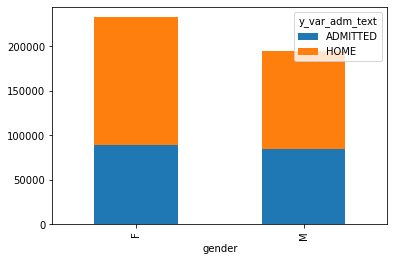

In [39]:
edstays_admit_1.groupby(['gender', 'y_var_adm_text']).size().unstack().plot(kind='bar', stacked=True)

In [40]:
edstays_admit_1['race'].value_counts()

WHITE                                        230707
BLACK/AFRICAN AMERICAN                        76854
OTHER                                         20925
HISPANIC/LATINO - PUERTO RICAN                14144
WHITE - OTHER EUROPEAN                         9178
HISPANIC/LATINO - DOMINICAN                    8434
BLACK/CAPE VERDEAN                             7785
ASIAN                                          7519
ASIAN - CHINESE                                7456
WHITE - RUSSIAN                                6203
UNKNOWN                                        5143
BLACK/AFRICAN                                  4891
BLACK/CARIBBEAN ISLAND                         3701
HISPANIC OR LATINO                             3139
HISPANIC/LATINO - GUATEMALAN                   2385
ASIAN - ASIAN INDIAN                           1612
ASIAN - SOUTH EAST ASIAN                       1572
HISPANIC/LATINO - SALVADORAN                   1517
WHITE - BRAZILIAN                              1505
PORTUGUESE  

In [41]:
edstays_admit_1.loc[edstays_admit_1['race'].str.contains('WHITE'), 'race_color'] = 'WHITE'
edstays_admit_1.loc[edstays_admit_1['race'].str.contains('BLACK'), 'race_color'] = 'BLACK'
edstays_admit_1.loc[edstays_admit_1['race'].str.contains('ASIAN'), 'race_color'] = 'ASIAN'
edstays_admit_1.loc[edstays_admit_1['race'].str.contains('LATINO'), 'race_color'] = 'HISPANIC/LATINO'
edstays_admit_1.loc[edstays_admit_1['race'].str.contains('HISPANIC'), 'race_color'] = 'HISPANIC/LATINO'
edstays_admit_1.loc[edstays_admit_1['race_color'].isna(), 'race_color'] = 'OTHER'

In [42]:
edstays_admit_1.groupby(['race_color', 'y_var_adm_text']).size().unstack()

y_var_adm_text,ADMITTED,HOME
race_color,,
ASIAN,6288,12697
BLACK,29089,64142
HISPANIC/LATINO,9408,25452
OTHER,13181,18071
WHITE,115224,133711


[Text(0, 0, '0.67'),
 Text(0, 0, '0.69'),
 Text(0, 0, '0.73'),
 Text(0, 0, '0.58'),
 Text(0, 0, '0.54')]

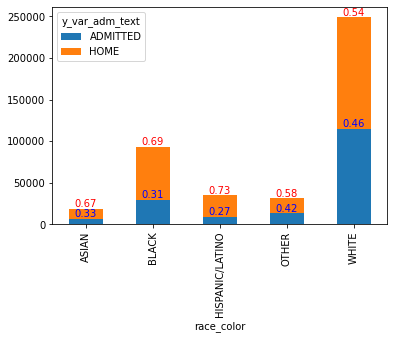

In [43]:
ax = edstays_admit_1.groupby(['race_color', 'y_var_adm_text']).size().unstack().plot(kind='bar', stacked=True)
percent = []
for i in range(len(ax.containers[0])):
    percent.extend([round( ax.containers[0].datavalues[i]/(ax.containers[0].datavalues[i]+ax.containers[1].datavalues[i]),2)])

ax.bar_label(ax.containers[0], labels=percent,color = "blue")
ax.bar_label(ax.containers[1], labels=[round((1 - i),2) for i in percent ],color = "red")

[Text(20, 0, '0.43'),
 Text(20, 0, '0.06'),
 Text(20, 0, '0.64'),
 Text(20, 0, '0.14'),
 Text(20, 0, '0.71')]

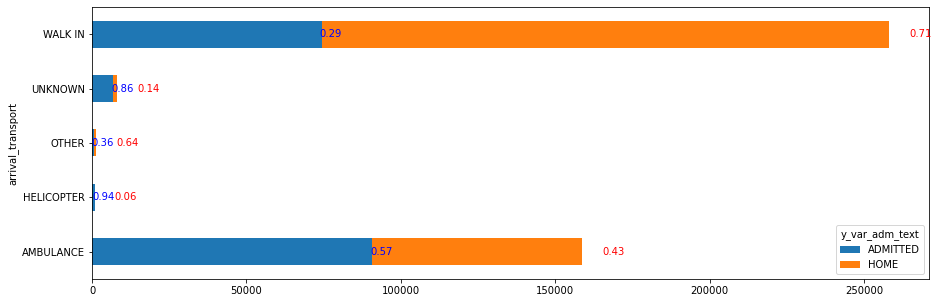

In [44]:
ax = edstays_admit_1.groupby(['arrival_transport', 'y_var_adm_text']).size().unstack().plot(kind='barh', stacked=True, rot = False, figsize = (15,5))
percent = []
for i in range(len(ax.containers[0])):
    percent.extend([round( ax.containers[0].datavalues[i]/(ax.containers[0].datavalues[i]+ax.containers[1].datavalues[i]),2)])

ax.bar_label(ax.containers[0], labels=percent,padding=-2,rotation=0, color = "blue")
ax.bar_label(ax.containers[1], labels=[round((1 - i),2) for i in percent ],padding=20, rotation=0, color = "red")

In [45]:
edstays_admit_1 = edstays_admit_1.sort_values(by = ['subject_id','DateTime_in'], ascending=True).reset_index(drop=True)

In [46]:
edstays_admit_1

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,key,key_diag,DateTime_in,DateTime_out,stay,race_color
0,10000032,22595853.0,33258284,6/5/2180 19:17,6/5/2180 23:30,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_33258284,10000032_33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,0 days 04:13:00,WHITE
1,10000032,22841357.0,38112554,26/6/2180 15:54,26/6/2180 21:31,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_38112554,10000032_38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,0 days 05:37:00,WHITE
2,10000032,29079034.0,32952584,22/7/2180 16:24,23/7/2180 5:54,F,WHITE,AMBULANCE,HOME,HOME,10000032_32952584,10000032_32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,0 days 13:30:00,WHITE
3,10000032,29079034.0,39399961,23/7/2180 5:54,23/7/2180 14:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_39399961,10000032_39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,0 days 08:06:00,WHITE
4,10000032,25742920.0,35968195,5/8/2180 20:58,6/8/2180 1:44,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_35968195,10000032_35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,0 days 04:46:00,WHITE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427258,19999784,24935234.0,37972930,9/7/2119 17:38,10/7/2119 0:04,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_37972930,19999784_37972930,2119-07-09 17:38:00,2119-07-10 00:04:00,0 days 06:26:00,BLACK
427259,19999784,25715748.0,34149746,11/8/2119 9:15,11/8/2119 13:40,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_34149746,19999784_34149746,2119-08-11 09:15:00,2119-08-11 13:40:00,0 days 04:25:00,BLACK
427260,19999828,29734428.0,30712109,17/7/2147 17:18,18/7/2147 17:34,F,WHITE,WALK IN,ADMITTED,ADMITTED,19999828_30712109,19999828_30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,1 days 00:16:00,WHITE
427261,19999828,25744818.0,32917002,8/1/2149 9:11,8/1/2149 18:12,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,19999828_32917002,19999828_32917002,2149-01-08 09:11:00,2149-01-08 18:12:00,0 days 09:01:00,WHITE


In [47]:
edstay_hist = {}
for i in range(len(edstays_admit_1)):
    if i == 0:
        edstay_hist[i] = 'NO HISTORY'
    else:
        if edstays_admit_1['subject_id'][i] == edstays_admit_1['subject_id'][i-1]:
            edstay_hist[i] = edstays_admit_1['y_var_adm_text'][i-1]
        else:
            edstay_hist[i] = 'NO HISTORY'

In [48]:
edstay_laststay = {}
for i in range(len(edstays_admit_1)):
    if i == 0:
        edstay_laststay[i] = np.timedelta64(0, 'D')
    else:
        if edstays_admit_1['subject_id'][i] == edstays_admit_1['subject_id'][i-1]:
            edstay_laststay[i] = edstays_admit_1['stay'][i-1]+edstay_laststay[i-1]
        else:
            edstay_laststay[i] = np.timedelta64(0, 'D')

In [49]:
df = pd.DataFrame.from_dict(edstay_hist,orient='index')
df.columns = ['historical_stay_status']

In [50]:
edstays_admit_1 = pd.merge(edstays_admit_1,df,how = 'left',left_index=True,right_index=True) 

In [51]:
df = pd.DataFrame.from_dict(edstay_laststay,orient='index')
df.columns = ['historical_stay_length']
edstays_admit_1 = pd.merge(edstays_admit_1,df,how = 'left',left_index=True,right_index=True) 

[Text(0, 0, '0.35'), Text(0, 0, '0.73'), Text(0, 0, '0.62')]

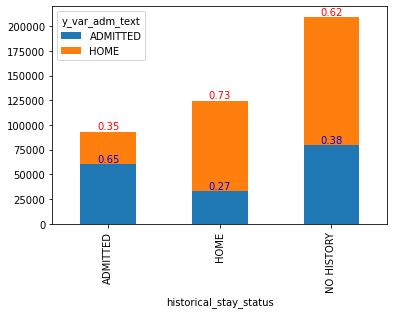

In [52]:
ax = edstays_admit_1.groupby(['historical_stay_status', 'y_var_adm_text']).size().unstack().plot(kind='bar', stacked=True)
percent = []
for i in range(len(ax.containers[0])):
    percent.extend([round( ax.containers[0].datavalues[i]/(ax.containers[0].datavalues[i]+ax.containers[1].datavalues[i]),2)])

ax.bar_label(ax.containers[0], labels=percent,color = "blue")
ax.bar_label(ax.containers[1], labels=[round((1 - i),2) for i in percent ],color = "red")

In [53]:
edstays_admit_1['historical_stay_length_in_day'] = edstays_admit_1['historical_stay_length']/(np.timedelta64(1, 'D'))



In [54]:
edstays_admit_1

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,key,key_diag,DateTime_in,DateTime_out,stay,race_color,historical_stay_status,historical_stay_length,historical_stay_length_in_day
0,10000032,22595853.0,33258284,6/5/2180 19:17,6/5/2180 23:30,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_33258284,10000032_33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,0 days 04:13:00,WHITE,NO HISTORY,0 days 00:00:00,0.000000
1,10000032,22841357.0,38112554,26/6/2180 15:54,26/6/2180 21:31,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_38112554,10000032_38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,0 days 05:37:00,WHITE,ADMITTED,0 days 04:13:00,0.175694
2,10000032,29079034.0,32952584,22/7/2180 16:24,23/7/2180 5:54,F,WHITE,AMBULANCE,HOME,HOME,10000032_32952584,10000032_32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,0 days 13:30:00,WHITE,ADMITTED,0 days 09:50:00,0.409722
3,10000032,29079034.0,39399961,23/7/2180 5:54,23/7/2180 14:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_39399961,10000032_39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,0 days 08:06:00,WHITE,HOME,0 days 23:20:00,0.972222
4,10000032,25742920.0,35968195,5/8/2180 20:58,6/8/2180 1:44,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_35968195,10000032_35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,0 days 04:46:00,WHITE,ADMITTED,1 days 07:26:00,1.309722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427258,19999784,24935234.0,37972930,9/7/2119 17:38,10/7/2119 0:04,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_37972930,19999784_37972930,2119-07-09 17:38:00,2119-07-10 00:04:00,0 days 06:26:00,BLACK,ADMITTED,0 days 06:48:00,0.283333
427259,19999784,25715748.0,34149746,11/8/2119 9:15,11/8/2119 13:40,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_34149746,19999784_34149746,2119-08-11 09:15:00,2119-08-11 13:40:00,0 days 04:25:00,BLACK,ADMITTED,0 days 13:14:00,0.551389
427260,19999828,29734428.0,30712109,17/7/2147 17:18,18/7/2147 17:34,F,WHITE,WALK IN,ADMITTED,ADMITTED,19999828_30712109,19999828_30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,1 days 00:16:00,WHITE,NO HISTORY,0 days 00:00:00,0.000000
427261,19999828,25744818.0,32917002,8/1/2149 9:11,8/1/2149 18:12,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,19999828_32917002,19999828_32917002,2149-01-08 09:11:00,2149-01-08 18:12:00,0 days 09:01:00,WHITE,ADMITTED,1 days 00:16:00,1.011111


<AxesSubplot:xlabel='y_var_adm_text', ylabel='historical_stay_length_in_day'>

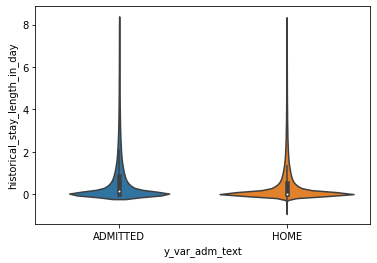

In [86]:
df = edstays_admit_1['historical_stay_length_in_day']
df = df[(np.abs(stats.zscore(df)) < 2)]
df = pd.merge(df,edstays_admit_1['y_var_adm_text'],how = 'left',left_index=True,right_index=True)
sns.violinplot(x = 'y_var_adm_text', y = 'historical_stay_length_in_day', data = df)

## 1.3 Triage table

In [56]:
triage = look_n_load('raw/triage.csv')


Shape: (447712, 11)

Columns: ['subject_id', 'stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint']

Missing proportions:
 subject_id        0.000000
stay_id           0.000000
temperature       0.054935
heartrate         0.040111
resprate          0.047743
o2sat             0.048355
sbp               0.042941
dbp               0.044823
pain              0.030415
acuity            0.016368
chiefcomplaint    0.000051
dtype: float64


In [57]:
t_count = pd.DataFrame(triage.groupby(['subject_id', 'stay_id'])['stay_id'].count()) 

t_count[t_count['stay_id']>1]

,,stay_id
subject_id,stay_id,


each person per stay id only have 1 triage record

In [58]:
triage_1 = pd.merge(edstays_admit_1[['subject_id', 'stay_id','y_var_adm_text']],triage,how = 'left',on=['subject_id', 'stay_id'])


In [59]:
triage_1

,subject_id,stay_id,y_var_adm_text,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10000032,33258284,ADMITTED,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention"
1,10000032,38112554,ADMITTED,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention
2,10000032,32952584,HOME,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension
3,10000032,39399961,ADMITTED,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC"
4,10000032,35968195,ADMITTED,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain"
...,...,...,...,...,...,...,...,...,...,...,...,...
427258,19999784,37972930,ADMITTED,98.0,91.0,16.0,99.0,148.0,90.0,5,2.0,Abnormal MRI
427259,19999784,34149746,ADMITTED,98.8,92.0,18.0,100.0,122.0,77.0,0,3.0,Wound eval
427260,19999828,30712109,ADMITTED,98.1,83.0,18.0,100.0,107.0,75.0,8,2.0,"Abd pain, Wound eval"
427261,19999828,32917002,ADMITTED,96.6,112.0,18.0,100.0,110.0,82.0,4,2.0,"Abd pain, Wound eval"


array([[<AxesSubplot:title={'center':'temperature'}>,
        <AxesSubplot:title={'center':'heartrate'}>,
        <AxesSubplot:title={'center':'resprate'}>],
       [<AxesSubplot:title={'center':'o2sat'}>,
        <AxesSubplot:title={'center':'sbp'}>,
        <AxesSubplot:title={'center':'dbp'}>],
       [<AxesSubplot:title={'center':'acuity'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

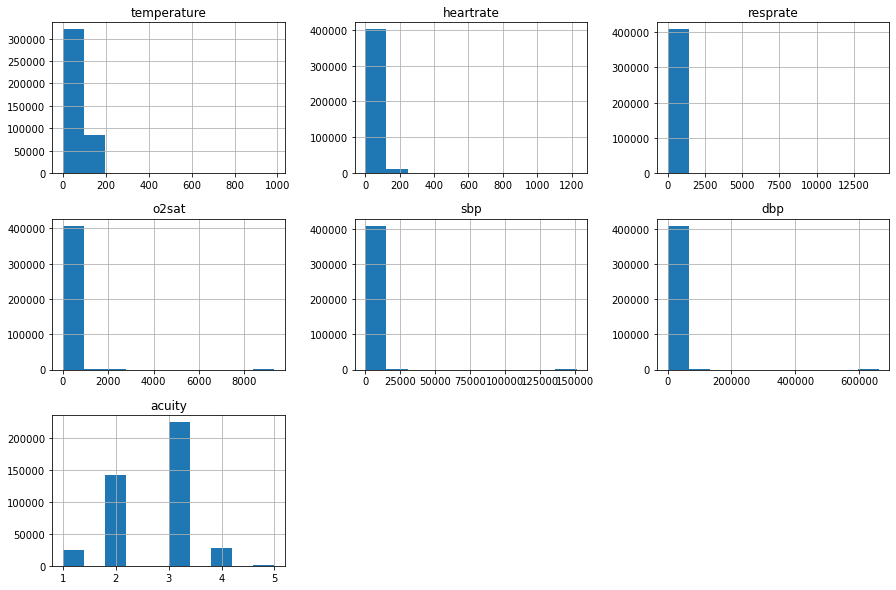

In [60]:
triage_1[['temperature','heartrate','resprate','o2sat','sbp','dbp','pain','acuity']].hist(figsize=[15,10])

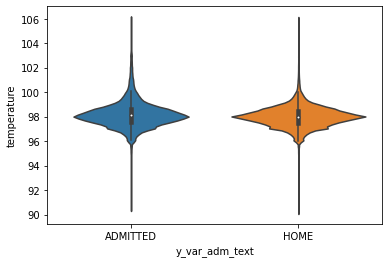

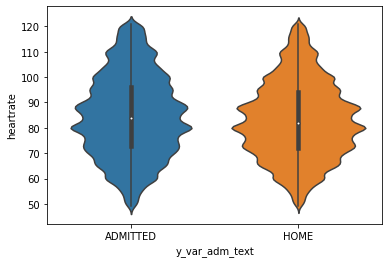

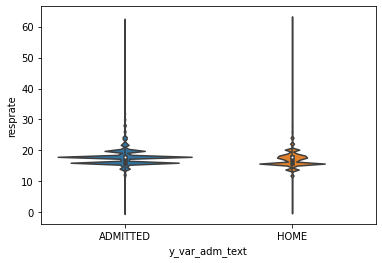

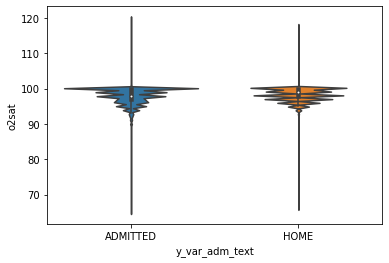

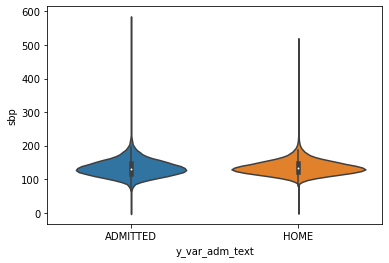

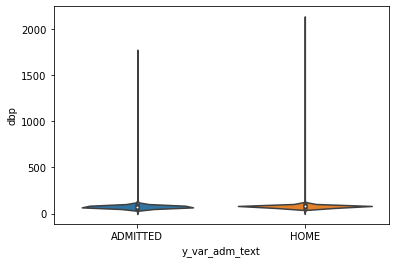

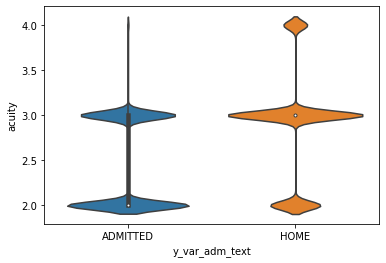

In [76]:
lst_col = ['temperature','heartrate','resprate','o2sat','sbp','dbp','acuity']
for i in lst_col:
    plt.figure()
    df = triage_1[[i]].dropna()
    df = df[(np.abs(stats.zscore(df)) < 2)]
    df = pd.merge(df,triage_1['y_var_adm_text'],how = 'left',left_index=True,right_index=True)
    sns.violinplot(x = 'y_var_adm_text', y = i, data = df)

In [80]:
triage_1['y_var'] = 0
triage_1.loc[triage_1['y_var_adm_text'] == 'ADMITTED','y_var'] = 1

In [81]:
triage_1.drop(['subject_id','stay_id'],axis = 1).corr()

,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,y_var
temperature,1.000000,0.049628,0.001732,-0.000867,0.025879,-0.000110,-0.003062,0.016056
heartrate,0.049628,1.000000,0.016274,-0.008993,0.000237,0.001480,-0.121458,0.074045
resprate,0.001732,0.016274,1.000000,-0.001177,0.000295,-0.000057,-0.018387,0.017300
o2sat,-0.000867,-0.008993,-0.001177,1.000000,0.000439,0.000213,0.024242,-0.025003
sbp,0.025879,0.000237,0.000295,0.000439,1.000000,0.004011,0.001678,-0.003758
dbp,-0.000110,0.001480,-0.000057,0.000213,0.004011,1.000000,0.000989,-0.002264
acuity,-0.003062,-0.121458,-0.018387,0.024242,0.001678,0.000989,1.000000,-0.377567
y_var,0.016056,0.074045,0.017300,-0.025003,-0.003758,-0.002264,-0.377567,1.000000


<AxesSubplot:>

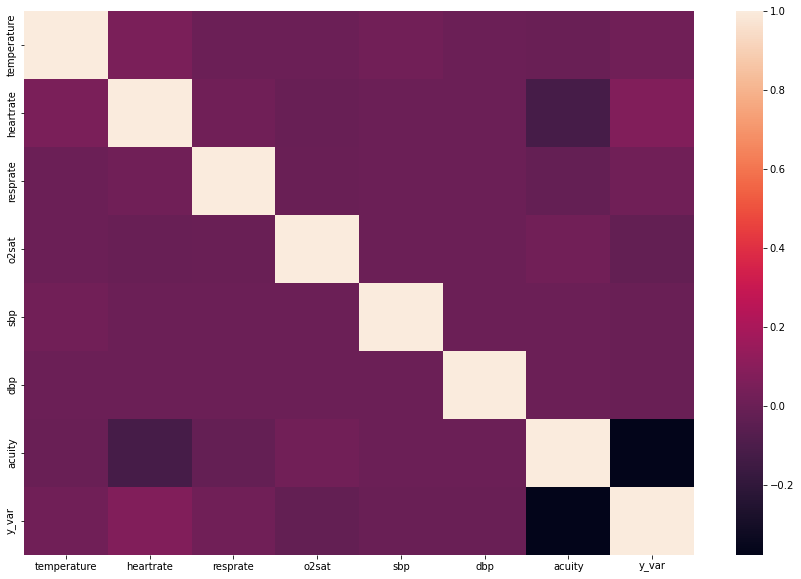

In [82]:
plt.figure(figsize=(15, 10))

sns.heatmap(triage_1.drop(['subject_id','stay_id'],axis = 1).corr())
